# Solving vanilla European options of Black-Scholes equation with Physics-informed Neural Networks

Recall that if we are using the Black-Scholes option pricing model then its value can be modeled as a function $V(S,t)$ that follows the PDE

$$\begin{align*}
    \frac{\partial V}{\partial t} + \frac{\sigma^2S^2}{2} \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0
\end{align*}$$
with the price $S$, risk-free rate $r$ and (fixed) volatility $\sigma$. This PDE is not meant to be solved forward in time since in most cases, we know how the payoff looks like at maturity so the question is to see how we can price the option right now (or at the inital time). In other words, this is a terminal value problem. Note that if we have a maturity time $t = T$ then by the change of variable $\tau = T - t$ then we can reduce the problem down to an initial value problem. This notebook will explore solving this setup with Physics-informed Neural Network (PINN) with respect to the vanilla European call options $V(S,T) = \max(S-K,0)$ for the strike price $K$. 

All of this means we training a Neural Network to solve the differential equation $V(S,\tau)$ on the time-evolution domain $[S_{min}, S_{max}] \times [0,T]$ of the following form 
$$\begin{align*}
    -\frac{\partial V}{\partial \tau} + \frac{\sigma^2S^2}{2} \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0 
\end{align*}$$
with the boundary conditions
$$\begin{align*}
    & V(S,0) = \max(S-K) \\
    & V(S_{max}, \tau) = S_{max} - Ke^{-r\tau} \\
    & V(S_{min}, \tau) = 0
\end{align*}$$
Even though the inputs is meant to be of the form $(S,\tau)$, we to make it consistent with the original setup, the inputs will be $(S,t)$ and the variable change $t \to \tau$ will be made internally of the model before training and predicting.

On the implementation side, for the architecture, instead of the usual multi layer perceptron (MLP), the Kolmogorov-Arnold Network (KAN) will since this notebook project goal is 2-fold for me which is understand the dynamics of the Black-Scholes model while also gain some intuition and exposure to the KAN network.

Of course, to test the performance of the model, we will benchmark it against the known analytical solution 
$$\begin{align*}
    V_{analytical}(S,t) = S\Phi(d_+) - Ke^{-r(T-t)}\Phi(d_-)
\end{align*}$$
where $\Phi(z)$ is the cummulative distribution function (CDF) of the standard normal distribution and 
$$\begin{align*}
    d_+ = \frac{1}{\sigma\sqrt{T-t}} \left( \ln\left(\frac{S}{K}\right) + t\left(\frac{r + \frac{\sigma^2}{2}}{2}\right) \right) \qquad \text{with} \qquad d_- = d_+ - \sigma\sqrt{t}
\end{align*}$$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from kan import KAN
import torch.optim as optim
from scipy.stats import norm
import seaborn as sns

In [2]:
# Backend setup 
torch.cuda.empty_cache()
# Set seed
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)

# CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# (Static) parameters that setup the Black-Scholes problem
# It can be a nice exercise in the future (if I ever revisit) is to pull market data and update the paramter based on the real data

param = {
    "Risk-free rate": 0.1,      # r
    "Volatility"    : 0.01,     # sigma
    "Strike price"  : 100,      # K
    "Price range"   : [50,150], # [S_min, S_max]
    "Time range"    : [0,0.25]  # [t_0, T]
}

# Paramters to set up the KAN feedforward network
KAN_param = {
    "Layers"        : [2,32,32,32,32,1],
    "Grid size"     : 10,
    "Spline order"  : 5,
    "Learning rate" : 1e-3,
    "Model path"    : "Black-scholes-EU-call-KAN-pinn.pth"
}

Note that even though the paramters chosen here are static, they were deliberately chosen since according to this [paper](https://faculty.haas.berkeley.edu/walden/HaasWebpage/benchop.pdf), these paramters will give a more challenging setting with respect to developing numerical models for Black-Scholes.

In [4]:
# Boundary conditions for the Black-Scholes model
# This will implement the European call option
def terminal_condition(S,K):
    return torch.maximum(S-K , torch.zeros_like(S))

def max_boundary(S_max, K, r, T ,t):
    return S_max - K*torch.exp(-r*(T-t))

def min_boundary(t):
    return torch.zeros_like(t)

conditions = {
    "Terminal condition": terminal_condition,
    "Max boundary"      : max_boundary,
    "Min boundary"      : min_boundary
}

In [11]:
class BlackScholesPINN:
    def __init__(self, param=param, KAN_param=KAN_param, conditions=conditions, device=device):
        # Black-Scholes
        self.r = param["Risk-free rate"]
        self.sigma = param["Volatility"]
        self.K = param["Strike price"]
        self.S_min , self.S_max = param["Price range"]
        self.t_0 , self.T = param["Time range"]

        # Boundary and terminal conditions
        self.terminal_condition = conditions["Terminal condition"]
        self.boundary_max = conditions["Max boundary"]
        self.boundary_min = conditions["Min boundary"]

        # Feedforward (Kolmogorov-Arnold) Neural Network
        self.model = KAN(width=KAN_param["Layers"],
                        grid=KAN_param["Grid size"],
                        k=KAN_param["Spline order"],
                        auto_save=False).to(device)
        
        self.device = device
        self.model_path = KAN_param["Model path"]

        # Optimizers and scheduler
        self.optimizer = optim.Adam(self.model.parameters(), lr=KAN_param["Learning rate"])
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode="min", factor=0.5, patience=100,  min_lr=1e-6)
        #self.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=300, T_mult=1, eta_min=1e-8)


        # Loss tracker
        self.loss_tracker = {"total" : [], "residual" : [], "terminal" : [], "max_price" : [], "min_price" : [], "MSE" : []}
    
    def residual(self, S, tau):
        # Make inputs to be tensors that requires grad
        S.requires_grad_(True)
        tau.requires_grad_(True)

        # Forward pass
        inputs = torch.cat([S, tau], dim=1)
        V = self.model(inputs)
        
        # Derivatives
        V_tau = torch.autograd.grad(
            outputs = V,
            inputs = tau,
            grad_outputs=torch.ones_like(V),
            create_graph=True , retain_graph=True
        )[0]

        V_S = torch.autograd.grad(
            outputs = V,
            inputs = S,
            grad_outputs=torch.ones_like(V),
            create_graph=True , retain_graph=True
        )[0]

        V_SS = torch.autograd.grad(
            outputs = V_S,
            inputs = S,
            grad_outputs=torch.ones_like(V_S),
            create_graph=True , retain_graph=True
        )[0]

        # PDE residual
        return -V_tau + (V_SS / 2.0)*(self.sigma * S)**2 + (self.r * S * V_S) - (self.r * V)
    
    def loss(self, n_collocation_pts=5000, n_terminal_pts=1000, n_each_boundary_pts=2000):

        # Sampling and calculating loss at interior points where PDE condition need to be met
        S_collocations = torch.rand(n_collocation_pts, 1, device=self.device) * (self.S_max - self.S_min) + self.S_min
        tau_collocations = self.T - (torch.rand(n_collocation_pts, 1, device=self.device) * (self.T - self.t_0) + self.t_0)
        residual_loss = torch.mean(self.residual(S_collocations, tau_collocations)**2)

        # Sampling and calculating at the minimum-price boundary
        S_bc_min = torch.full((n_each_boundary_pts, 1), self.S_min, device=self.device)
        t_bc_min = torch.rand(n_each_boundary_pts, 1, device=self.device) * (self.T - self.t_0) + self.t_0
        tau_bc_min = self.T - t_bc_min
        input_min_price = torch.cat([S_bc_min, tau_bc_min], dim=1)
        V_min_pred = self.model(input_min_price)
        V_min_true = self.boundary_min(t_bc_min)
        min_price_loss = torch.mean((V_min_pred - V_min_true)**2)
        

        # Sampling boundary points at S_max
        S_bc_max = torch.full((n_each_boundary_pts, 1), self.S_max, device=self.device)
        t_bc_max = torch.rand(n_each_boundary_pts, 1, device=self.device) * (self.T - self.t_0) + self.t_0
        tau_bc_max = self.T - t_bc_max
        V_max_pred = self.model(torch.cat([S_bc_max, tau_bc_max], dim=1))
        V_max_true = self.boundary_max(self.S_max, self.K, self.r, self.T, t_bc_max)
        max_price_loss = torch.mean((V_max_pred - V_max_true)**2)

        # Sampling Terminal condition points
        S_terminal = torch.rand(n_terminal_pts, 1, device=self.device) * (self.S_max - self.S_min) + self.S_min
        tau_terminal = torch.full((n_terminal_pts, 1), 0.0, device=self.device)
        input_terminal = torch.cat([S_terminal, tau_terminal], dim=1)
        V_terminal_pred = self.model(input_terminal)
        V_terminal_true = self.terminal_condition(S_terminal, self.K)
        terminal_loss = torch.mean((V_terminal_true - V_terminal_pred)**2)

        # Compute the total loss (note that this supposed to be a linear combination of the previous losses)
        total_loss = 20*residual_loss + 5*terminal_loss + min_price_loss + 15*max_price_loss

        return total_loss, residual_loss, terminal_loss, min_price_loss,  max_price_loss


    def train(self, epochs=2001, print_interval=100):
        # Setup the model to be trained
        self.model.train()
        self.model.speed()  # This is needed for parallelization in the training

        #smallest_mse = float("inf")
        smallest_loss = float("inf")
        best_epoch = 0
        for epoch in range(epochs):
            # Zero-out gradients as usual for training
            self.optimizer.zero_grad()

            # Calculate loss
            total_loss, residual_loss, terminal_loss, min_price_loss,  max_price_loss = self.loss(n_collocation_pts=3000, 
                                                                                                n_terminal_pts=2000, 
                                                                                                n_each_boundary_pts=1500)
            # Backpropagate and update
            total_loss.backward()
            self.optimizer.step()
            self.scheduler.step(total_loss)

            # Storing the losses
            self.loss_tracker["total"].append(total_loss.item())
            self.loss_tracker["residual"].append(residual_loss.item())
            self.loss_tracker["terminal"].append(terminal_loss.item())
            self.loss_tracker["max_price"].append(max_price_loss.item())
            self.loss_tracker["min_price"].append(min_price_loss.item())

            # Saving the best model
            mse = residual_loss + terminal_loss + max_price_loss + min_price_loss
            if (total_loss < smallest_loss):
                best_epoch = epoch
                smallest_loss = total_loss
                torch.save({"Model states" : self.model.state_dict(),
                            "Losses" : self.loss_tracker,
                            "Best epoch" : best_epoch}, 
                            self.model_path)
                
            self.loss_tracker["MSE"].append(mse.item())

            # Print training info when it"s time
            if (epoch % print_interval) == 0:
                print(f"Epoch {epoch:4d}: Total Loss = {total_loss.item():.6f} | Residual loss = {residual_loss.item():.6f} | Termial loss = {terminal_loss.item():.6f} | "
                      f"Max Price loss = {max_price_loss.item():.6f} | Min Price Loss = {min_price_loss.item():.6f} | "
                      f"MSE: {mse.item():.6f}")
            
        # After training, print the best possible loss and associated epoch
        print(f"Best model occured at epoch {best_epoch}, with lowest loss of {smallest_loss}")

    def predict(self, S, t):
        self.model.eval()
        with torch.no_grad():
            tau = self.T - t
            input = torch.cat([S, tau], dim=1)
            return self.model(input)
    
    def _Black_Scholes_formula(self, S, t):
        # Computing Black-Scholes formula within the interior (non-boundary points)
        tau = self.T - t 
        d_plus = (torch.log(S/self.K) + tau*(self.r + self.sigma**2/2.0)) / (self.sigma * torch.sqrt(tau))
        d_minus = d_plus - self.sigma*torch.sqrt(tau)
        return S*torch.special.ndtr(d_plus) - torch.special.ndtr(d_minus)*(self.K*torch.exp(-self.r*(tau)))

    def analytical_solution(self, S, t):

        # Note that the B-S formula does not apply (and not even make sense) at the boundary so we need to deal with them seperately
        at_maturity = (self.T - t) < 1e-10
        zero_price = S < 1e-10

        # If-else but using PyTorch (yes, it's jank but this works for tensor vectorization)
        solution = torch.where(at_maturity, self.terminal_condition(S, self.K),
                   torch.where(zero_price, torch.zeros_like(S),
                   self._Black_Scholes_formula(S,t)))
        
        return solution
            
    def load_model(self, model_path):
        try:
            model_info = torch.load(model_path, map_location=self.device)
            self.model.load_state_dict(model_info["Model states"])
            self.loss_tracker = model_info["Losses"]
            #print(f"Best epoch: {model_info["Best epoch"]}") # Testing
        except:
            print("Error loading model")

    def benchmark(self, n_test_points=1000):

        self.load_model(self.model_path)

        # Create meshgrid for benchmarking
        S_vals = torch.linspace(self.S_min, self.S_max, n_test_points, device=self.device)
        t_vals = torch.linspace(self.t_0, self.T, n_test_points, device=self.device)
        S_mesh, t_mesh = torch.meshgrid(S_vals, t_vals, indexing="ij")
        
        S_flat = S_mesh.reshape(-1, 1)
        t_flat = t_mesh.reshape(-1, 1)
        
        # Get predictions and analytical solutions
        V_pred = self.predict(S_flat, t_flat).cpu().numpy()
        V_analytical = self.analytical_solution(S_flat, t_flat).cpu().numpy()
        
        # Reshape for plotting
        V_pred = V_pred.reshape(n_test_points, n_test_points)
        V_analytical = V_analytical.reshape(n_test_points, n_test_points)
        error = np.abs(V_pred - V_analytical)
        
        # Convert meshgrid to numpy for plotting
        S_mesh_np = S_mesh.cpu().numpy()
        t_mesh_np = t_mesh.cpu().numpy()
        
        # Create the 2x2 subplot
        fig = plt.figure(figsize=(15, 12))
        
        # PINN Prediction
        ax1 = fig.add_subplot(2, 2, 1, projection="3d")
        surf1 = ax1.plot_surface(S_mesh_np, t_mesh_np, V_pred, cmap="viridis", alpha=0.8)
        ax1.set_xlabel("S")
        ax1.set_ylabel("t")
        ax1.set_zlabel("V(S,t)")
        ax1.set_title("PINN Prediction")
        
        # Analytical Solution
        ax2 = fig.add_subplot(2, 2, 2, projection="3d")
        surf2 = ax2.plot_surface(S_mesh_np, t_mesh_np, V_analytical, cmap="viridis", alpha=0.8)
        ax2.set_xlabel("S")
        ax2.set_ylabel("t")
        ax2.set_zlabel("V(S,t)")
        ax2.set_title("Analytical Solution")
        
        # Error Heatmap
        ax3 = fig.add_subplot(2, 2, 3)
        im = ax3.imshow(error.T, extent=[self.S_min, self.S_max, self.t_0, self.T], 
                        aspect="auto", origin="lower", cmap="Reds")
        ax3.set_ylabel("t")
        ax3.set_xlabel("S")
        ax3.set_title("Absolute Error")
        plt.colorbar(im, ax=ax3)
        
        # Comparison with the initial time
        V_pred_t0 = V_pred[:,0]
        V_analytical_t0 = V_analytical[:,0]

        ax4 = fig.add_subplot(2, 2, 4)
        ax4.plot(S_mesh_np[:, 0], V_pred_t0, "r--", label="PINN Prediction")
        ax4.plot(S_mesh_np[:, 0], V_analytical_t0, "b-", label="Analytical")
        ax4.set_xlabel("S")
        ax4.set_ylabel("Option Value")
        ax4.set_title(f"Comparison at Initial time: t_0 = {self.t_0}")
        ax4.legend()
        ax4.grid(True)

        plt.tight_layout()
        plt.show()
        
        # Error benchmark
        # Whole time evolution grid
        max_error = np.max(error)
        mean_error = np.mean(error)
        rmse = np.sqrt(np.mean(error**2))
        print("Error for prediction throughout whole time-evolution grid")
        print(f"Maximum absolute error: {max_error:.6f}")
        print(f"Mean absolute error: {mean_error:.6f}")
        print(f"Root Mean Square Error: {rmse:.6f}")
        print(f"Relative error (% of mean option value): {100 * mean_error / np.mean(V_analytical):.2f}%")
        print("=================================================\n")

        # At initial time (i.e. the option pricing time)
        error_t0 = error[:,0]
        max_error_t0 = np.max(error_t0)
        mean_error_t0 = np.mean(error_t0)
        rmse_t0 = np.sqrt(np.mean(error_t0**2))
        print(f"Error for prediction at t_0 = {self.t_0:.2f}")
        print(f"Maximum absolute error: {max_error_t0:.6f}")
        print(f"Mean absolute error: {mean_error_t0:.6f}")
        print(f"Root Mean Square Error: {rmse_t0:.6f}")
        print(f"Relative error (% of mean option value): {100 * mean_error_t0 / np.mean(V_analytical_t0):.2f}%")
        print("=================================================\n")

        # Max-error location
        max_error_idx = np.unravel_index(np.argmax(error), error.shape)
        max_error_S = S_mesh_np[max_error_idx]
        max_error_t = t_mesh_np[max_error_idx]
        print(f"Maximum error location:  S = {max_error_S:.2f}, t = {max_error_t:.4f}")

    
    def plot_training_stats(self):
        # Right now I'm just plotting the losses. If I ever revisit, I'll plot more stats like learning rate and such 
        self.load_model(self.model_path)
        
        fig = plt.figure(figsize=(10,8))
        ax1 = fig.add_subplot(1,1,1)
        ax1.semilogy(self.loss_tracker["total"], label="Total loss")
        ax1.semilogy(self.loss_tracker["residual"], label="Residual loss")
        ax1.semilogy(self.loss_tracker["terminal"], label="Terminal loss")
        ax1.semilogy(self.loss_tracker["max_price"], label="Max price BC loss")
        ax1.semilogy(self.loss_tracker["min_price"], label="Min price BC loss")

        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training Loss History")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [6]:
BSP = BlackScholesPINN()
BSP.train(epochs=3001, print_interval=300)

Epoch    0: Total Loss = 39786.914062 | Residual loss = 0.000064 | Termial loss = 404.141510 | Max Price loss = 2517.740234 | Min Price Loss = 0.105099 | MSE: 2921.986816
Epoch  300: Total Loss = 443.268463 | Residual loss = 0.406774 | Termial loss = 80.386658 | Max Price loss = 2.010309 | Min Price Loss = 3.045074 | MSE: 85.848816
Epoch  600: Total Loss = 6.819295 | Residual loss = 0.023381 | Termial loss = 0.485949 | Max Price loss = 0.258823 | Min Price Loss = 0.039586 | MSE: 0.807739
Epoch  900: Total Loss = 1.230424 | Residual loss = 0.012662 | Termial loss = 0.071714 | Max Price loss = 0.040965 | Min Price Loss = 0.004155 | MSE: 0.129495
Epoch 1200: Total Loss = 2.239472 | Residual loss = 0.002807 | Termial loss = 0.028985 | Max Price loss = 0.135892 | Min Price Loss = 0.000028 | MSE: 0.167712
Epoch 1500: Total Loss = 0.105999 | Residual loss = 0.002028 | Termial loss = 0.008804 | Max Price loss = 0.001411 | Min Price Loss = 0.000251 | MSE: 0.012494
Epoch 1800: Total Loss = 0.056

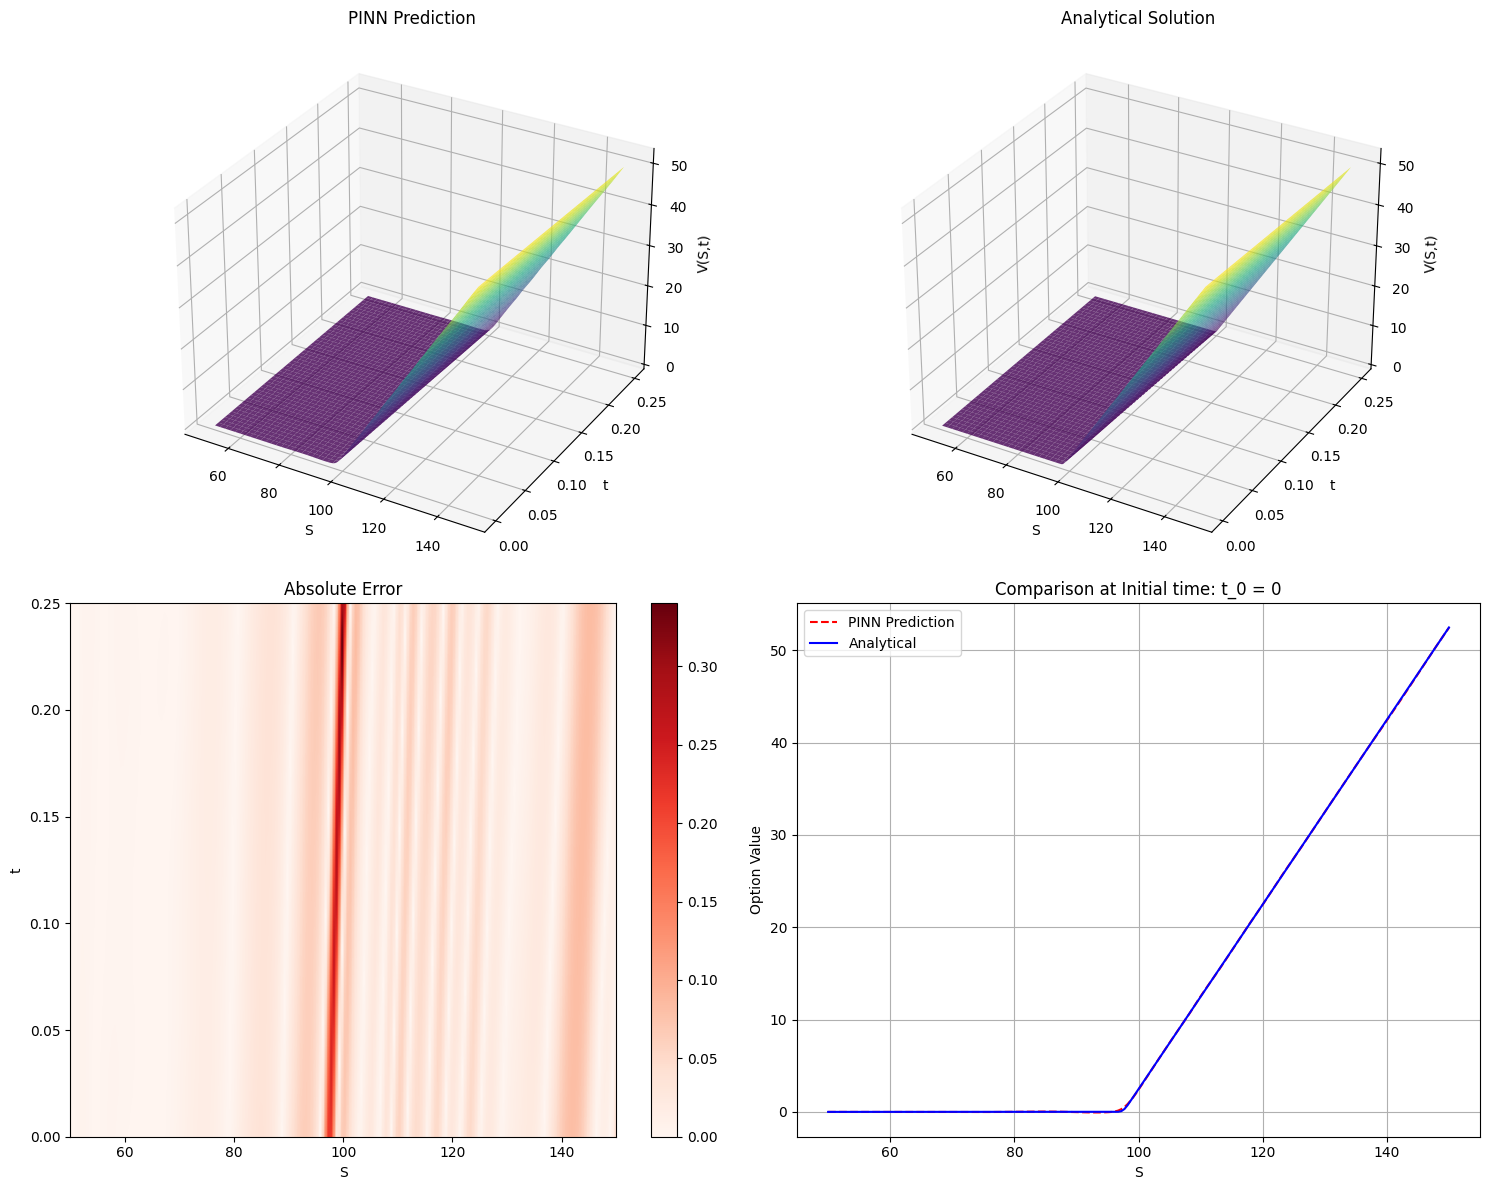

Error for prediction throughout whole time-evolution grid
Maximum absolute error: 0.340355
Mean absolute error: 0.025402
Root Mean Square Error: 0.041458
Relative error (% of mean option value): 0.19%

Error for prediction at t_0 = 0.00
Maximum absolute error: 0.218290
Mean absolute error: 0.024498
Root Mean Square Error: 0.038657
Relative error (% of mean option value): 0.18%

Maximum error location:  S = 99.75, t = 0.2312


In [ ]:
BSP.benchmark(n_test_points=200)

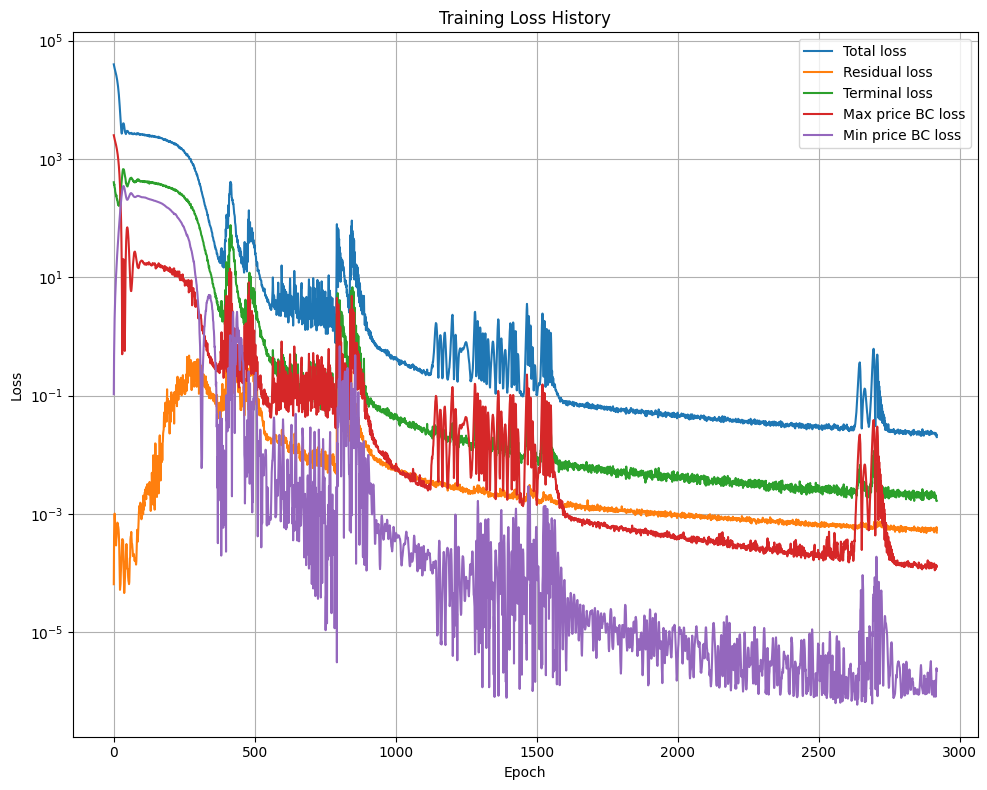

In [8]:
BSP.plot_training_stats()

The produced model in the end is a pretty good model, and of course as expected the location with the most error is near the strike price since that is the location with sharp gradients and PINNs (or Neural Networks more generally) are known for the tendancy to fit smooth functions and can not deal with singularities well.